## **Passenger prediction with XGBRegressor** 
~ Hendrico Burger 

In [8]:
import numpy as np 
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.stattools as stats
import statsmodels.formula.api as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt
import statsmodels as stat
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

import datetime
import hvplot.pandas 
from scipy.stats import norm
import optuna

from workalendar.europe import NetherlandsWithSchoolHolidays as NL

In [7]:
pip install "optuna"

     |████████████████████████████████| 348 kB 29.8 MB/s            
     |████████████████████████████████| 210 kB 43.8 MB/s            
     |████████████████████████████████| 81 kB 8.7 MB/s             
     |████████████████████████████████| 78 kB 7.5 MB/s             
     |████████████████████████████████| 50 kB 12.1 MB/s            
     |████████████████████████████████| 147 kB 58.1 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 112 kB 61.1 MB/s            
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11124 sha256=d38c0fd30d49410c3581b8236ba329aa1d80860db2462328f9ce7abc54da2047
  Stored in directory: /home/datalore/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled

In [4]:
df = pd.read_csv(r'cleandata.csv')

# get datetime dates and redefine a new dataframe with variable of interest.
ts = pd.to_datetime(df['Geplande datum/tijd'], errors='coerce')
red_df = df[['Pay pax', 'Maatschappij', 'BookedPayPax']]
red_df['timestamp'] = ts
red_df

/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,9,11,12,15,18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-4-93f515ceb154>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_df['timestamp'] = ts


,Pay pax,Maatschappij,BookedPayPax,timestamp
0,NaN,NaN,NaN,2021-08-31 08:50:00
1,NaN,NaN,NaN,2021-08-31 07:00:00
2,NaN,NaN,NaN,2021-08-31 07:14:00
3,NaN,NaN,NaN,2021-08-31 06:15:00
4,NaN,NaN,NaN,2021-08-31 07:10:00
...,...,...,...,...
857156,NaN,NaN,NaN,2021-03-24 10:10:00
857157,NaN,NaN,4.0,2021-06-11 05:30:00
857158,NaN,NaN,NaN,2021-03-18 20:00:00
857159,NaN,Air Hamburg Private Jets,2.0,2020-05-28 13:36:00


## Feature engineering 

Performed on the "data" datbase

In [9]:
data = (red_df.set_index('timestamp')
        .resample('D').sum()
        ['2014':'2019']
       )

# Function to find the number of the week in a month
def WeekNumber(date_value):
    week = date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1
    return date_value.isocalendar()[1] if week < 0 else week

# Rename for use in the regression
data = data.rename(columns={"Pay pax": "Pay_pax"})

data['Days_of_year'] = data.index.dayofyear
data['Month'] = data.index.month
data['Week'] = data.index.week
data['Week_Month'] = [WeekNumber(i) for i in data.index]
data['Day_Number'] = data.index.day

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['Day_Name'] = data.index.day_name()

data['Time'] = [i for i in range(len(data))]
data['Time2'] = data['Time']**2

data = data.fillna(0)

#Holidays
calendar = NL(region='south', carnival_instead_of_spring=True)
all_holidays = []
for i in list(data.index.year.unique())[2:]:
    for j in calendar.holidays(i):
        all_holidays.append(j[0])


data['Holidays'] = [1 if i in all_holidays else 0 for i in data.index]


#Rate of change
data['rate_of_change_L14'] = data["Pay_pax"].pct_change().shift(14)

#Lags

data['Pay_pax_L1'] = data['Pay_pax'].shift(1)
data['Pay_pax_L2'] = data['Pay_pax'].shift(2)
data['Pay_pax_L3'] = data['Pay_pax'].shift(3)
data["RM_10"] = data["Pay_pax"].rolling(10).mean()
data["SD_10"] = data["Pay_pax"].rolling(10).std()


# One data point is negative (to be retreated)
data[data['Pay_pax'] < 1] = 1
data

<ipython-input-9-c8522dbdd4ce>:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['Week'] = data.index.week


,Pay_pax,Days_of_year,Month,Week,Week_Month,Day_Number,Day_Name,Time,Time2,Holidays,rate_of_change_L14,Pay_pax_L1,Pay_pax_L2,Pay_pax_L3,RM_10,SD_10
timestamp,,,,,,,,,,,,,,,,
2014-01-01,3167.0,1,1,1,1,1,Wednesday,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,3361.0,2,1,1,1,2,Thursday,1,1,0,NaN,3167.0,NaN,NaN,NaN,NaN
2014-01-03,4828.0,3,1,1,1,3,Friday,2,4,0,NaN,3361.0,3167.0,NaN,NaN,NaN
2014-01-04,3023.0,4,1,1,1,4,Saturday,3,9,0,NaN,4828.0,3361.0,3167.0,NaN,NaN
2014-01-05,4821.0,5,1,1,1,5,Sunday,4,16,0,NaN,3023.0,4828.0,3361.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3937.0,361,12,52,5,27,Friday,2186,4778596,1,0.286506,3176.0,2647.0,3003.0,3221.1,423.751617
2019-12-28,3235.0,362,12,52,5,28,Saturday,2187,4782969,1,-0.578591,3937.0,3176.0,2647.0,3259.4,403.509383
2019-12-29,3810.0,363,12,52,5,29,Sunday,2188,4787344,1,0.845985,3235.0,3937.0,3176.0,3353.2,412.374641


## Visualisations 

<AxesSubplot:xlabel='timestamp'>

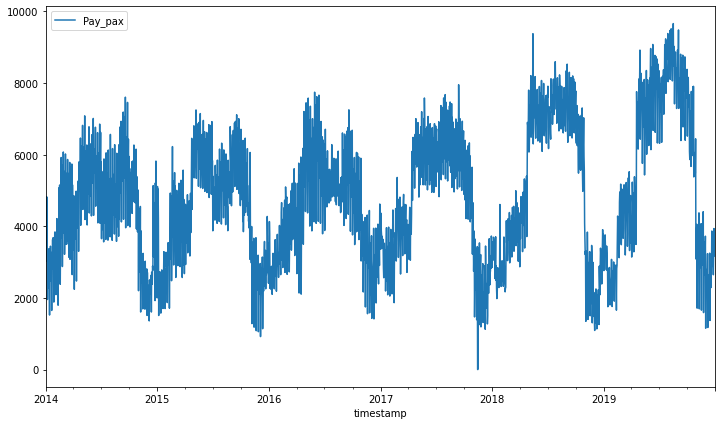

In [10]:
data[['Pay_pax']].plot(figsize=(12,7))

<AxesSubplot:xlabel='Month'>

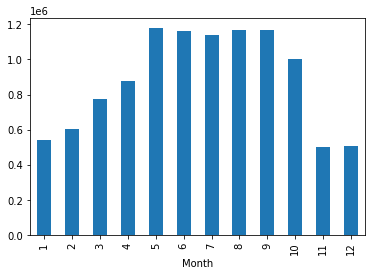

In [11]:
# Visualize possible seasonal effects (monthly)
(data.groupby('Month')
 .sum()
 ['Pay_pax']
 .plot.bar())

<AxesSubplot:xlabel='Week', ylabel='Pay_pax'>

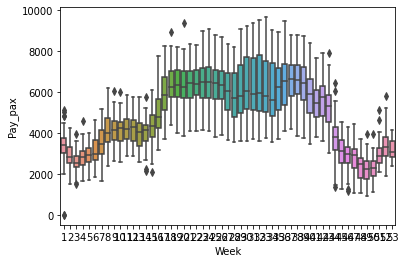

In [12]:
# Visualize possible seasonal effects (weekly)
sns.boxplot(data=data, x='Week', y='Pay_pax')

In [13]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
        
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout,(2,0))
        pp_ax = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Serie Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sma.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


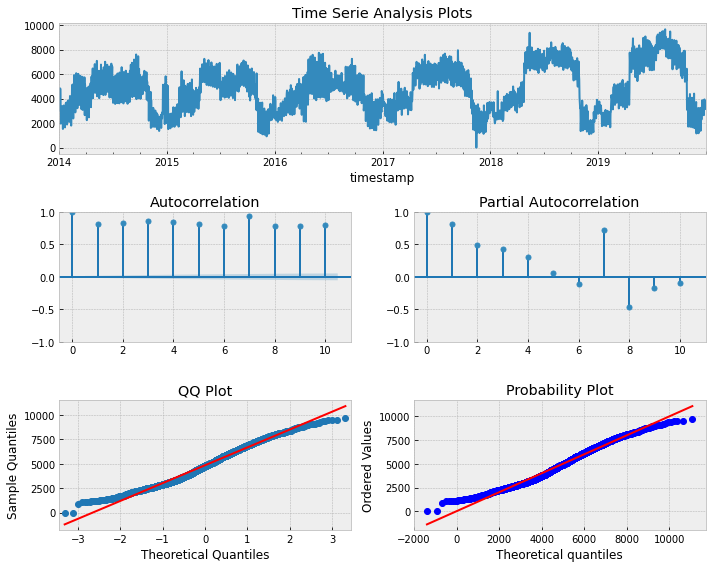

In [8]:
tsplot(data['Pay_pax'], lags=10)

In [ ]:
#High 7 day autocorrelation. Weekly cycle should be included

## XGBRegressor

In [8]:
predict_date = len(data) - len(data[:'2018'])
predict_date

365

In [109]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [14]:
data

,Pay_pax,Days_of_year,Month,Week,Week_Month,Day_Number,Day_Name,Time,Time2,Holidays,rate_of_change_L14,Pay_pax_L1,Pay_pax_L2,Pay_pax_L3,RM_10,SD_10
timestamp,,,,,,,,,,,,,,,,
2014-01-01,3167.0,1,1,1,1,1,Wednesday,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,3361.0,2,1,1,1,2,Thursday,1,1,0,NaN,3167.0,NaN,NaN,NaN,NaN
2014-01-03,4828.0,3,1,1,1,3,Friday,2,4,0,NaN,3361.0,3167.0,NaN,NaN,NaN
2014-01-04,3023.0,4,1,1,1,4,Saturday,3,9,0,NaN,4828.0,3361.0,3167.0,NaN,NaN
2014-01-05,4821.0,5,1,1,1,5,Sunday,4,16,0,NaN,3023.0,4828.0,3361.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3937.0,361,12,52,5,27,Friday,2186,4778596,1,0.286506,3176.0,2647.0,3003.0,3221.1,423.751617
2019-12-28,3235.0,362,12,52,5,28,Saturday,2187,4782969,1,-0.578591,3937.0,3176.0,2647.0,3259.4,403.509383
2019-12-29,3810.0,363,12,52,5,29,Sunday,2188,4787344,1,0.845985,3235.0,3937.0,3176.0,3353.2,412.374641


In [10]:
def trial(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True )
    max_depth = trial.suggest_int("max_depth", 10, 1000)
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)

    data["RM_10_L" + str(28)] = data["RM_10"].shift(28)
    data["SD_10_L" + str(28)] = data["SD_10"].shift(28)

    y_to_train = data["2016":"2018"]
    y_to_val = data[" 2019":]

    X_train_L = y_to_train[["Month", "Week", "Week_Month", "Holidays", "RM_10_L" + str(28), "SD_10_L" + str(28)]]
    y_train_L = y_to_train.Pay_pax.values
    X_val_L = y_to_val[["Month", "Week", "Week_Month", "Holidays", "RM_10_L" + str(28), "SD_10_L" + str(28)]]
    y_val_L = y_to_val.Pay_pax.values
    
    model = XGBRegressor(lr = lr, max_depth = max_depth, n_estimators = n_estimators)
    model.fit(X_train_L, y_train_L)
    pred = model.predict(X_val_L)

    rmse = np.sqrt(mean_squared_error(y_val_L, pred))
    return rmse

study = optuna.create_study()
study.optimize(trial, n_trials = 100, show_progress_bar=True)

[08:16:27] WARNING: ../src/learner.cc:576: 
Parameters: { "lr" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[I 2022-12-20 08:16:28,997] Trial 0 finished with value: 1010.1397362992969 and parameters: {'lr': 0.018071805072866858, 'max_depth': 41, 'n_estimators': 184}. Best is trial 0 with value: 1010.1397362992969.
[08:16:29] WARNING: ../src/learner.cc:576: 
Parameters: { "lr" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[I 2022-12-20 08:16:29,216] Trial 1 finished with value: 1019.5187006063087 and parame

[I 2022-12-20 08:16:27,808] A new study created in memory with name: no-name-0a011c9a-b89a-467c-b5c1-9f70c0b443ad
/opt/python/envs/default/lib/python3.8/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


KeyboardInterrupt: KeyboardInterrupt: 

In [17]:
optuna.visualization.plot_slice(study)

### XGBRegressor subpart: 
*weekly importance prediction*

In [16]:
def shift_predictions(shift, data):
    
    y_to_train = data['2016':'2018'] # dataset to train
    y_to_val = data['2019':] # last X months for test
    
    X_train_L = y_to_train[["Month", "Week", "Week_Month", "Holidays", "RM_10_L" + str(shift), "SD_10_L" + str(shift)]]
    y_train_L = y_to_train.Pay_pax.values
    X_val_L = y_to_val[["Month", "Week", "Week_Month", "Holidays", "RM_10_L" + str(shift), "SD_10_L" + str(shift)]]
    y_val_L = y_to_val.Pay_pax.values

    model_XGBR = XGBRegressor()
    model_XGBR.fit(X_train_L, y_train_L)
    pred = model_XGBR.predict(X_val_L)

    return pred, y_val_L

#shift_predictions(7, data)
#shift_predictions(14, data)
#shift_predictions(21, data)
#shift_predictions(28, data)
'''
shift_df = pd.DataFrame(data = 
                        {"7_shift" : [np.sqrt(mean_squared_error(shift_predictions(7, data)[1][0:7], shift_predictions(7, data)[0][0:7])),
                                    np.sqrt(mean_squared_error(shift_predictions(14, data)[1][0:7], shift_predictions(14, data)[0][0:7])),
                                    np.sqrt(mean_squared_error(shift_predictions(21, data)[1][0:7], shift_predictions(21, data)[0][0:7])),
                                    np.sqrt(mean_squared_error(shift_predictions(28, data)[1][0:7], shift_predictions(28, data)[0][0:7]))],
                        "14_shift" : [0, np.sqrt(mean_squared_error(shift_predictions(14, data)[1][7:14], shift_predictions(14, data)[0][7:14])),
                                    np.sqrt(mean_squared_error(shift_predictions(21, data)[1][7:14], shift_predictions(21, data)[0][7:14])),
                                    np.sqrt(mean_squared_error(shift_predictions(28, data)[1][7:14], shift_predictions(28, data)[0][7:14]))],
                        "21_shift" : [0,0, np.sqrt(mean_squared_error(shift_predictions(21, data)[1][14:21], shift_predictions(21, data)[0][14:21])),
                                    np.sqrt(mean_squared_error(shift_predictions(28, data)[1][14:21], shift_predictions(28, data)[0][14:21]))],
                        "28_shift" : [0,0,0, np.sqrt(mean_squared_error(shift_predictions(28, data)[1][21:28], shift_predictions(28, data)[0][21:28]))]})

shift_df.index = ["RMSE_7", "RMSE_L14", "RMSE_L21", "RMSE_L28"]
shift_df.index = ["RMSE_7", "RMSE_L14", "RMSE_L21", "RMSE_L28"]
shift_plot = shift_df.plot.barh(y = ["7_shift", "14_shift", "21_shift", "28_shift"])
shift_plot
                                  
'''
def get_comb_xgb(shift_list, date_range):
    xgb_data = data
    pred_list = []
    actual_list = []
    for shift in shift_list:
        print(shift)
        xgb_data["RM_10_L" + str(shift)] = data["RM_10"].shift(shift)
        xgb_data["SD_10_L" + str(shift)] = data["SD_10"].shift(shift)

        xgb_X_to_train = xgb_data.loc[date_range[0] : date_range[1]][["Month", "Week", "Week_Month", "Holidays", "RM_10_L" + str(shift), "SD_10_L" + str(shift)]]
        xgb_X_to_val = xgb_data.loc[date_range[1] : date_range[2]][["Month", "Week", "Week_Month", "Holidays", "RM_10_L" + str(shift), "SD_10_L" + str(shift)]]
        xgb_y_to_train = xgb_data.loc[date_range[0] : date_range[1]][["Pay_pax"]]
        xgb_actual = xgb_data.loc[date_range[1] : date_range[2]][["Pay_pax"]][int(shift - (max(shift_list)/len(shift_list))):shift].values.reshape(1,int(max(shift_list)/len(shift_list)))[0]

        model_xgb = XGBRegressor()
        model_xgb.fit(xgb_X_to_train, xgb_y_to_train)
        pred = model_xgb.predict(xgb_X_to_val)[int(shift - (max(shift_list)/len(shift_list))):shift]
        pred_list.extend(pred)
        actual_list.extend(xgb_actual)
        
        xgb_X_to_train.drop([("RM_10_L" + str(shift)), ("SD_10_L" + str(shift))], axis = 1)
        xgb_X_to_val.drop([("RM_10_L" + str(shift)), ("SD_10_L" + str(shift))], axis = 1)

    
    rmse = np.sqrt(mean_squared_error(actual_list, pred_list))
    mape = np.mean(abs(np.array(actual_list) - np.array(pred_list))/np.array(actual_list))*100
    
    return pred_list, rmse, mape
    
    
        
            


In [ ]:
round(len(data['Pay_pax'][400:])/7)

256

In [ ]:
## Cross-Validation

In [78]:
def Cross_Val(training_period, forecast_period, shift_list, options='RW', fig_display=True):
    '''
    
    Function to perform timeseries forecasting validation:
    INPUT: Training_period = int - length of the training sample
    INPUT: Forecasting_period = int - amount of days to predict
    INPUT: options = str - takes either RW (Rolling Windows) or EX (Expending window)
    OUTPUT: all_mse = list - all RMSE values
    OUTPUT: all_predic = list - all out of samples predictions
    
    '''
    all_mse = []
    all_predic = []
    all_mape = []
    start_training_date = data['Pay_pax'].index[0]
    end_training_date = data['Pay_pax'].index[training_period]
    nb_iter = len(data['Pay_pax'][end_training_date:])//int(max(shift_list)/len(shift_list)) #numbers of periods to predict
    print(nb_iter)
    
    # first iteration
    date_range = [start_training_date, end_training_date, (end_training_date + datetime.timedelta(days=forecast_period))]
    combined_pred, rmse, mape = get_comb_xgb(shift_list, date_range)
    
    all_mape.append(mape)
    all_mse.append(rmse)
    all_predic.append(combined_pred)

    
    if options=='RW':
        for i in range(1, nb_iter - int(len(shift_list)) + 1):
            print('iteration #'+str(i))
            start_training_date += datetime.timedelta(days=int(max(shift_list)/len(shift_list)))
            end_training_date += datetime.timedelta(days=int(max(shift_list)/len(shift_list)))
            date_range = [start_training_date, end_training_date, (end_training_date + datetime.timedelta(days=forecast_period)) ]
            combined_pred, rmse, mape = get_comb_xgb(shift_list, date_range)
            
            all_mape.append(mape)
            all_mse.append(rmse)
            all_predic.append(combined_pred)
            
    elif options == 'EX':
        for i in range(1, nb_iter - int(len(shift_list)) + 1):
            print('iteration #'+str(i))
            end_training_date += datetime.timedelta(days=int(max(shift_list)/len(shift_list)))
            date_range = [start_training_date, end_training_date, (end_training_date + datetime.timedelta(days=forecast_period)) ]
            combined_pred, rmse, mape = get_comb_xgb(shift_list, date_range)
            
            all_mape.append(mape)
            all_mse.append(rmse)
            all_predic.append(combined_pred)
        
    else: 
        print('Options type not recognized: Please choose either RW or EX')
        return None
        
        
    if fig_display==True: 
        
        pd.DataFrame(all_mse).plot(figsize=(15,5))
        
        
    return all_mse, all_predic, all_mape

In [79]:
#all_mse1, all_predic1, all_mape1 = Cross_Val(training_period=400, forecast_period=28, shift_list = [7,14,21,28], options='RW', fig_display=False)
#all_mse2, all_predic2, all_mape2 = Cross_Val(training_period=400, forecast_period=28, shift_list = [7,14,21,28], options='EX', fig_display=False)
#all_mse3, all_predic3, all_mape3 = Cross_Val(training_period=400, forecast_period=28, shift_list = [28], options='RW', fig_display=False)
all_mse4, all_predic4, all_mape4 = Cross_Val(training_period=400, forecast_period=28, shift_list = [28], options='EX', fig_display=False)

63
28
iteration #1
28
iteration #2
28
iteration #3
28
iteration #4
28
iteration #5
28
iteration #6
28
iteration #7
28
iteration #8
28
iteration #9
28
iteration #10
28
iteration #11
28
iteration #12
28
iteration #13
28
iteration #14
28
iteration #15
28
iteration #16
28
iteration #17
28
iteration #18
28
iteration #19
28
iteration #20
28
iteration #21
28
iteration #22
28
iteration #23
28
iteration #24
28
iteration #25
28
iteration #26
28
iteration #27
28
iteration #28
28
iteration #29
28
iteration #30
28
iteration #31
28
iteration #32
28
iteration #33
28
iteration #34
28
iteration #35
28
iteration #36
28
iteration #37
28
iteration #38
28
iteration #39
28
iteration #40
28
iteration #41
28
iteration #42
28
iteration #43
28
iteration #44
28
iteration #45
28
iteration #46
28
iteration #47
28
iteration #48
28
iteration #49
28
iteration #50
28
iteration #51
28
iteration #52
28
iteration #53
28
iteration #54
28
iteration #55
28
iteration #56
28
iteration #57
28
iteration #58
28
iteration #59
28


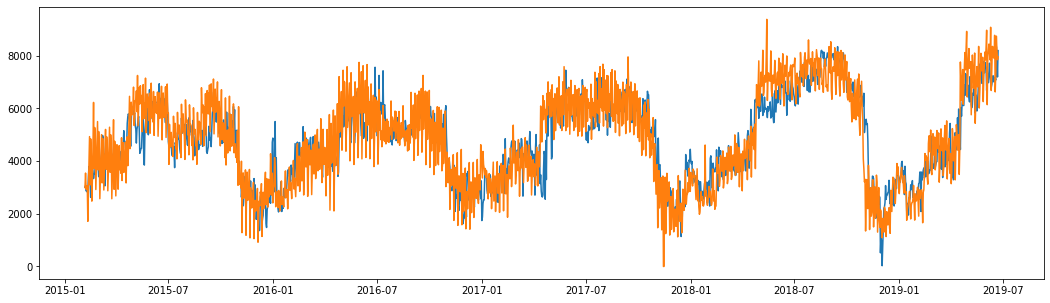

In [108]:
plt.figure(figsize=(18, 5))
plt.plot(pd.DataFrame([i for sub in all_predic4 for i in sub][:1600], data.index[400:2000]))
plt.plot(data.Pay_pax[400:2000])



In [110]:
mean_absolute_percentage_error(data.Pay_pax[400:2000], [i for sub in all_predic4 for i in sub][:1600])

4.208417407671017

In [112]:
np.sqrt(mean_squared_error(data.Pay_pax[400:2000], [i for sub in all_predic4 for i in sub][:1600]))

952.2524504822954

<AxesSubplot:xlabel='timestamp'>

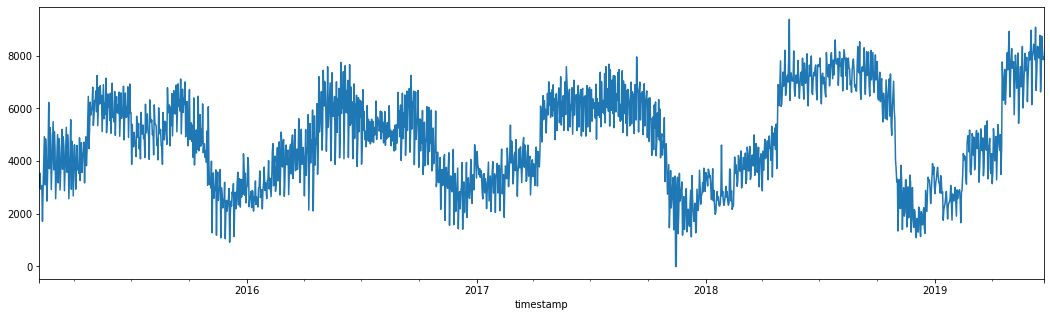

In [98]:
data.Pay_pax[400:2000].plot(figsize=(18,5))

In [87]:
(len([i for sub in all_predic4 for i in sub])/28)

63.0

In [91]:
data.Pay_pax.index[400:]

DatetimeIndex(['2015-02-05', '2015-02-06', '2015-02-07', '2015-02-08',
               '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12',
               '2015-02-13', '2015-02-14',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='timestamp', length=1791, freq=None)